# Description
In this project, we will explore the Stanford Open Policing Project dataset and try to find out the impact of gender on police behavior. You can collect data for any state from this [website](https://openpolicing.stanford.edu/data/). In the project we collect data from Rhode Island.

## 1. Preparing data for analysis
First we have to clean our dataset and ensure that it don't contain duplicates, handle missing values and fixing data types

In [1]:
# import libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data
police = pd.read_csv('../input/police-datasets/police.csv')
weather = pd.read_csv('../input/police-datasets/weather.csv')

In [3]:
# Understand the data

# Examine the head of the DataFrame
print(police.head())

# Count the number of missing values in each column
print(police.isnull().sum())

  state   stop_date stop_time  county_name driver_gender driver_race  \
0    RI  2005-01-04     12:55          NaN             M       White   
1    RI  2005-01-23     23:15          NaN             M       White   
2    RI  2005-02-17     04:15          NaN             M       White   
3    RI  2005-02-20     17:15          NaN             M       White   
4    RI  2005-02-24     01:20          NaN             F       White   

                    violation_raw  violation  search_conducted search_type  \
0  Equipment/Inspection Violation  Equipment             False         NaN   
1                        Speeding   Speeding             False         NaN   
2                        Speeding   Speeding             False         NaN   
3                Call for Service      Other             False         NaN   
4                        Speeding   Speeding             False         NaN   

    stop_outcome is_arrested stop_duration  drugs_related_stop district  
0       Citation       F

In [4]:
# We have to dropped all those columns which are not useful for our analysis like county_name and state
# county_name contains all missing values
# state in our case is Rhode Island so we don't need it

# Examine the shape of the DataFrame
print(police.shape)

# Drop the 'county_name' and 'state' columns
police.drop(['county_name', 'state'], axis='columns', inplace=True)

# Examine the shape of the DataFrame (again)
print(police.shape)

(91741, 15)
(91741, 13)


In [5]:
# Dataset have some specific columns which are important for our analysis, if there's a small no of 
# rows have missing values in it, it's oky to remove them.
# driver_gender is a critical column for our analysis which contain some missing values so we drop
# some of these rows

# Count the number of missing values in each column
print(police.isnull().sum())

# Drop all rows that are missing 'driver_gender'
police.dropna(subset=['driver_gender'], inplace=True)

# Count the number of missing values in each column (again)
print(police.isnull().sum())

# Examine the shape of the DataFrame
print(police.shape)

stop_date                 0
stop_time                 0
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64
stop_date                 0
stop_time                 0
driver_gender             0
driver_race               0
violation_raw             0
violation                 0
search_conducted          0
search_type           83229
stop_outcome              0
is_arrested               0
stop_duration             0
drugs_related_stop        0
district                  0
dtype: int64
(86536, 13)


In [6]:
# examine the datatype of each column
print(police.dtypes)

# we need to fix the datatype of is_arrested to bool
# Examine the head of the 'is_arrested' column
print(police.is_arrested.head())

# Change the data type of 'is_arrested' to 'bool'
police['is_arrested'] = police.is_arrested.astype('bool')

# Check the data type of 'is_arrested' 
print(police['is_arrested'].dtype)

stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation_raw         object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
stop_duration         object
drugs_related_stop      bool
district              object
dtype: object
0    False
1    False
2    False
3     True
4    False
Name: is_arrested, dtype: object
bool


In [7]:
# date and time of each traffic stop are present in different columns, we have to combine into a 
# single column called stop_datetime

# Concatenate 'stop_date' and 'stop_time' (separated by a space)
combined = police.stop_date.str.cat(police.stop_time, sep=' ')

# Convert 'combined' to datetime format
police['stop_datetime'] = pd.to_datetime(combined)

# Examine the data types of the DataFrame
print(police.dtypes)

stop_date                     object
stop_time                     object
driver_gender                 object
driver_race                   object
violation_raw                 object
violation                     object
search_conducted                bool
search_type                   object
stop_outcome                  object
is_arrested                     bool
stop_duration                 object
drugs_related_stop              bool
district                      object
stop_datetime         datetime64[ns]
dtype: object


In [8]:
# We will analyze our dataset mostly by date and time 
# so it's good to make stop_datetime dataframe index

# Set 'stop_datetime' as the index
police.set_index('stop_datetime', inplace=True)

# Examine the index
print(police.index)

# Examine the columns
print(police.columns)

DatetimeIndex(['2005-01-04 12:55:00', '2005-01-23 23:15:00',
               '2005-02-17 04:15:00', '2005-02-20 17:15:00',
               '2005-02-24 01:20:00', '2005-03-14 10:00:00',
               '2005-03-29 21:55:00', '2005-04-04 21:25:00',
               '2005-07-14 11:20:00', '2005-07-14 19:55:00',
               ...
               '2015-12-31 13:23:00', '2015-12-31 18:59:00',
               '2015-12-31 19:13:00', '2015-12-31 20:20:00',
               '2015-12-31 20:50:00', '2015-12-31 21:21:00',
               '2015-12-31 21:59:00', '2015-12-31 22:04:00',
               '2015-12-31 22:09:00', '2015-12-31 22:47:00'],
              dtype='datetime64[ns]', name='stop_datetime', length=86536, freq=None)
Index(['stop_date', 'stop_time', 'driver_gender', 'driver_race',
       'violation_raw', 'violation', 'search_conducted', 'search_type',
       'stop_outcome', 'is_arrested', 'stop_duration', 'drugs_related_stop',
       'district'],
      dtype='object')


## 2. Identify relationship between gender and police
Now that our dataset is clean, we are ready to analyze our data and try to answer the question 
Does gender of a driver have differnet influence of police behavior on decisions during traffic stop?

In [9]:
# Analyze violation committed by all drivers

# Count the unique values in 'violation'
print(police.violation.value_counts())

# Express the counts as proportions
print(police.violation.value_counts(normalize=True))

Speeding               48423
Moving violation       16224
Equipment              10921
Other                   4409
Registration/plates     3703
Seat belt               2856
Name: violation, dtype: int64
Speeding               0.559571
Moving violation       0.187483
Equipment              0.126202
Other                  0.050950
Registration/plates    0.042791
Seat belt              0.033004
Name: violation, dtype: float64


In [10]:
# Analyze different gender committed different violations

# Create a DataFrame of female drivers
female = police[police['driver_gender'] == 'F']

# Create a DataFrame of male drivers
male = police[police['driver_gender'] == 'M']

# Compute the violations by female drivers (as proportions)
print('Female violations: \n{}'.format(female['violation'].value_counts(normalize=True)))

# Compute the violations by male drivers (as proportions)
print('Male violations: \n{}'.format(male['violation'].value_counts(normalize=True)))

Female violations: 
Speeding               0.658114
Moving violation       0.138218
Equipment              0.105199
Registration/plates    0.044418
Other                  0.029738
Seat belt              0.024312
Name: violation, dtype: float64
Male violations: 
Speeding               0.522243
Moving violation       0.206144
Equipment              0.134158
Other                  0.058985
Registration/plates    0.042175
Seat belt              0.036296
Name: violation, dtype: float64


In [11]:
# Does gender has an impact of receiving a ticket and warning of over speeding when they pulled over?

# Create a DataFrame of female drivers stopped for speeding
female_and_speeding = police[(police.driver_gender == 'F') & (police.violation == 'Speeding')]

# Create a DataFrame of male drivers stopped for speeding
male_and_speeding = police[(police.driver_gender == 'M') & (police.violation == 'Speeding')]

# Compute the stop outcomes for female drivers (as proportions)
print('Female stop_outcome: \n{}'.format(female_and_speeding.stop_outcome.value_counts(normalize=True)))

# Compute the stop outcomes for male drivers (as proportions)
print('Male stop_outcome: \n{}'.format(male_and_speeding.stop_outcome.value_counts(normalize=True)))


Female stop_outcome: 
Citation            0.952192
Warning             0.040074
Arrest Driver       0.005752
N/D                 0.000959
Arrest Passenger    0.000639
No Action           0.000383
Name: stop_outcome, dtype: float64
Male stop_outcome: 
Citation            0.944595
Warning             0.036184
Arrest Driver       0.015895
Arrest Passenger    0.001281
No Action           0.001068
N/D                 0.000976
Name: stop_outcome, dtype: float64


In [12]:
# Calculate the search rate (police search vehicles when needed)

# Check the data type of 'search_conducted'
print(police.search_conducted.dtype)

# Calculate the search rate by counting the values
print(police.search_conducted.value_counts(normalize=True))

# Calculate the search rate by taking the mean
print(police.search_conducted.mean())

bool
False    0.961785
True     0.038215
Name: search_conducted, dtype: float64
0.0382153092354627


In [13]:
# Only 3.8% police conduct searches on vehicles, now we need to know how gender impact on search rate

# Calculate the search rate for both groups simultaneously
print(police.groupby('driver_gender').search_conducted.mean())

driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64


In [14]:
# Police conduct seaches on mostly males drivers but it also depend on different factors like 
# violation type, now we analyze how police conduct searches based on different violations by gender

# Calculate the search rate for each combination of gender and violation
print(police.groupby(['driver_gender', 'violation']).search_conducted.mean())
print('\n----------------------------\n')
# Reverse the ordering to group by violation before gender
print(police.groupby(['violation', 'driver_gender']).search_conducted.mean())

driver_gender  violation          
F              Equipment              0.039984
               Moving violation       0.039257
               Other                  0.041018
               Registration/plates    0.054924
               Seat belt              0.017301
               Speeding               0.008309
M              Equipment              0.071496
               Moving violation       0.061524
               Other                  0.046191
               Registration/plates    0.108802
               Seat belt              0.035119
               Speeding               0.027885
Name: search_conducted, dtype: float64

----------------------------

violation            driver_gender
Equipment            F                0.039984
                     M                0.071496
Moving violation     F                0.039257
                     M                0.061524
Other                F                0.041018
                     M                0.046191
Registration/p

In [15]:
# We need to find out how many drivers have protective frisk search (frisk is when a person is
# investigate for having a weapon)

# Count the 'search_type' values
print(police['search_type'].value_counts())

# Check if 'search_type' contains the string 'Protective Frisk'
police['frisk'] = police.search_type.str.contains('Protective Frisk', na=False)

# Check the data type of 'frisk'
print(police.frisk.dtype)

# Take the sum of 'frisk'
print(police.frisk.sum())

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Incident to Arrest,Inventory,Probable Cause                   35
Probable Cause,Protective Frisk                               35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

In [16]:
# Now compare the frisk rates with the gender

# Create a DataFrame of stops in which a search was conducted
searched = police[police.search_conducted == True]

# Calculate the overall frisk rate by taking the mean of 'frisk'
print(searched.frisk.mean())

# Calculate the frisk rate for each gender
print(searched.groupby('driver_gender').frisk.mean())

0.09162382824312065
driver_gender
F    0.074561
M    0.094353
Name: frisk, dtype: float64


## 3. Visual exploratory data analysis
Now, we identify the trend visually and try to find out the relation between time of day and driver arrested, also answer questions like Are drugs stop on the rise of day.

In [17]:
# We need to calculate the arrest rate and also the arrest rate per hour

# Calculate the overall arrest rate
print(police.is_arrested.mean())

# Calculate the hourly arrest rate
print(police.groupby(police.index.hour).is_arrested.mean())

# Save the hourly arrest rate
hourly_arrest_rate = police.groupby(police.index.hour).is_arrested.mean()

0.0355690117407784
stop_datetime
0     0.051431
1     0.064932
2     0.060798
3     0.060549
4     0.048000
5     0.042781
6     0.013813
7     0.013032
8     0.021854
9     0.025206
10    0.028213
11    0.028897
12    0.037399
13    0.030776
14    0.030605
15    0.030679
16    0.035281
17    0.040619
18    0.038204
19    0.032245
20    0.038107
21    0.064541
22    0.048666
23    0.047592
Name: is_arrested, dtype: float64


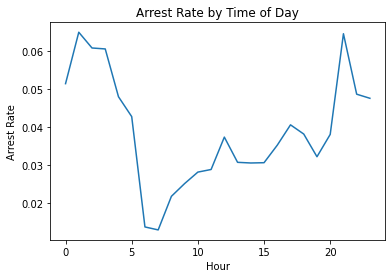

In [18]:
# Create an line plot to identify the trend arrest_rate per hour

# Create a line plot of 'hourly_arrest_rate'
plt.plot(hourly_arrest_rate)

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')

# Display the plot
plt.show()

stop_datetime
2005-12-31    0.006501
2006-12-31    0.007258
2007-12-31    0.007970
2008-12-31    0.007505
2009-12-31    0.009889
2010-12-31    0.010081
2011-12-31    0.009731
2012-12-31    0.009921
2013-12-31    0.013094
2014-12-31    0.013826
2015-12-31    0.012266
Freq: A-DEC, Name: drugs_related_stop, dtype: float64


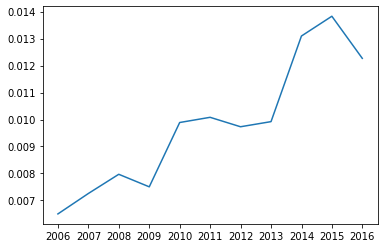

In [19]:
# Now we want to identify the trend how drug related stop change over time
#() drugs_related_stop: boolean when police stops you for searching drugs in a vehicle)
    
# Calculate the annual rate of drug-related stops
print(police.drugs_related_stop.resample('A').mean())

# Save the annual rate of drug-related stops
annual_drug_rate = police.drugs_related_stop.resample('A').mean()

# Create a line plot of 'annual_drug_rate'
plt.plot(annual_drug_rate)

# Display the plot
plt.show()

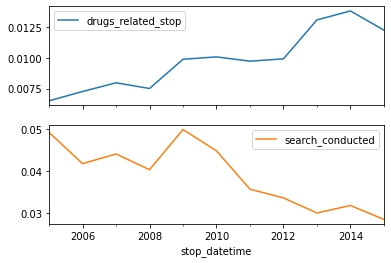

In [20]:
# As you can see it increases over 10 periods of time, now we want to check how it relates to searches
# conducted 

# Calculate and save the annual search rate
annual_search_rate = police.search_conducted.resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')

# Create subplots from 'annual'
annual.plot(subplots=True)

# Display the subplots
plt.show()

In [21]:
# We want to identify the trend between violations caught by police in different zones.

# Create a frequency table of districts and violations
print(pd.crosstab(police.district, police.violation))

# Save the frequency table as 'all_zones'
all_zones = pd.crosstab(police.district, police.violation)

# Select rows 'Zone K1' through 'Zone K3'
print(all_zones.loc['Zone K1': 'Zone K3'])

# Save the smaller table as 'k_zones'
k_zones = all_zones.loc['Zone K1': 'Zone K3']

violation  Equipment  Moving violation  Other  Registration/plates  Seat belt  \
district                                                                        
Zone K1          672              1254    290                  120          0   
Zone K2         2061              2962    942                  768        481   
Zone K3         2302              2898    705                  695        638   
Zone X1          296               671    143                   38         74   
Zone X3         2049              3086    769                  671        820   
Zone X4         3541              5353   1560                 1411        843   

violation  Speeding  
district             
Zone K1        5960  
Zone K2       10448  
Zone K3       12322  
Zone X1        1119  
Zone X3        8779  
Zone X4        9795  
violation  Equipment  Moving violation  Other  Registration/plates  Seat belt  \
district                                                                        
Zone K1      

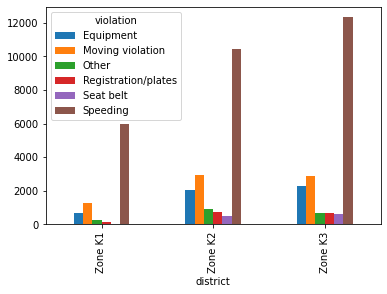

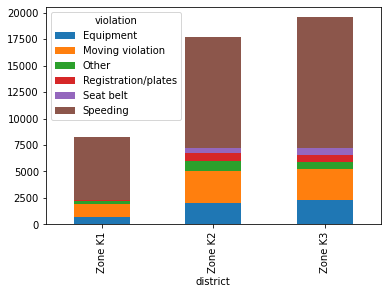

In [22]:
# Now we create an visualization which compare Zone k with different violations

# Create a bar plot of 'k_zones'
k_zones.plot(kind='bar')

# Display the plot
plt.show()

# Create a stacked bar plot of 'k_zones'
k_zones.plot(kind='bar', stacked=True)

# Display the plot
plt.show()

In [23]:
# Convert stop_duration to number for analyze data more efficent
# (stop_duration tells how much time police stops a driver)
# This is in a format of strings like '0-15 min'so we need to map it to numbers for 
# better understanding of data

# Print the unique values in 'stop_duration'
print(police.stop_duration.unique())

# Create a dictionary that maps strings to integers
mapping = {'0-15 Min': 8, '16-30 Min': 23, '30+ Min': 45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
police['stop_minutes'] = police.stop_duration.map(mapping)

# Print the unique values in 'stop_minutes'
print(police.stop_minutes.unique())

['0-15 Min' '16-30 Min' '30+ Min']
[ 8 23 45]


violation_raw
APB                                 17.967033
Call for Service                    22.124371
Equipment/Inspection Violation      11.445655
Motorist Assist/Courtesy            17.741463
Other Traffic Violation             13.844490
Registration Violation              13.736970
Seatbelt Violation                   9.662815
Special Detail/Directed Patrol      15.123632
Speeding                            10.581562
Suspicious Person                   14.910714
Violation of City/Town Ordinance    13.254144
Warrant                             24.055556
Name: stop_minutes, dtype: float64

-----------------------------------------------------



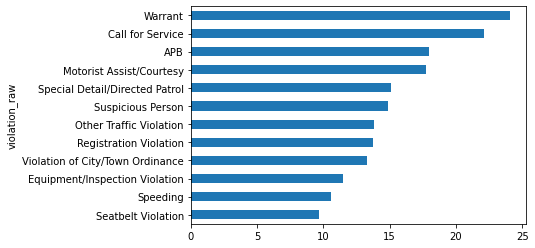

In [24]:
# visualize stop_minutes to see the trend for each violation

# Calculate the mean 'stop_minutes' for each value in 'violation_raw'
print(police.groupby('violation_raw').stop_minutes.mean())

# Save the resulting Series as 'stop_length'
stop_length = police.groupby('violation_raw').stop_minutes.mean()
print('\n-----------------------------------------------------\n')
# Sort 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind='barh')

# Display the plot
plt.show()

## 4. Analyze the effect of weather on police
Now we want to explore data in a way how police behavior change on different weather conditions during traffic stop.

              TMIN         TAVG         TMAX
count  4017.000000  1217.000000  4017.000000
mean     43.484441    52.493016    61.268608
std      17.020298    17.830714    18.199517
min      -5.000000     6.000000    15.000000
25%      30.000000    39.000000    47.000000
50%      44.000000    54.000000    62.000000
75%      58.000000    68.000000    77.000000
max      77.000000    86.000000   102.000000


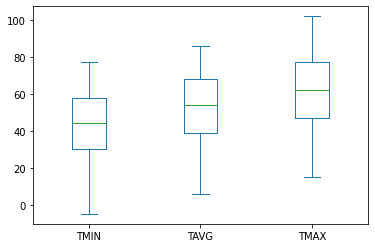

In [25]:
# First we will examine the temperature column to check our dataset is reliable or not

# Describe the temperature columns
print(weather[['TMIN', 'TAVG', 'TMAX']].describe())

# Create a box plot of the temperature columns
weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box')

# Display the plot
plt.show()

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


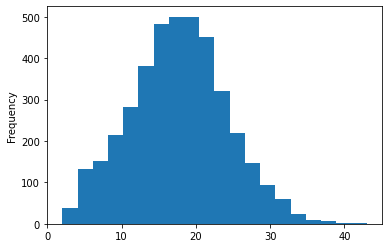

In [26]:
# to make sure about our data we take the different of max and min temperature
# we will create an histogram to check it's distribution for validity. (no value should be negative)

# Create a 'TDIFF' column that represents temperature difference
weather['TDIFF'] = weather['TMAX'] - weather['TMIN']

# Describe the 'TDIFF' column
print(weather['TDIFF'].describe())

# Create a histogram with 20 bins to visualize 'TDIFF'
weather['TDIFF'].plot(kind='hist', bins=20)

# Display the plot
plt.show()

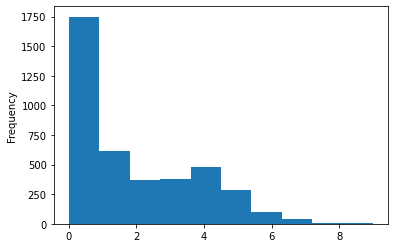

In [27]:
# count bad weather conditions, there are 3 columns we need to explore 
# WT05 indicates "Hail"
# WT11 indicates "High or damaging winds"
# WT17 indicates "Freezing rain"

# we count how bad weather each day

# Copy 'WT01' through 'WT22' to a new DataFrame
WT = weather.loc[:, 'WT01': 'WT22']

# Calculate the sum of each row in 'WT'
weather['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
weather['bad_conditions'].plot(kind='hist')

# Display the plot
plt.show()

In [28]:
# Now we will create a rating system to count bad weather

# Count the unique values in 'bad_conditions' and sort the index
print(weather.bad_conditions.value_counts().sort_index())

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad', 4: 'bad',5: 'worse', 6: 'worse', 7: 'worse', 8: 'worse', 9: 'worse',}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(weather['rating'].value_counts())

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
bad      1836
good     1749
worse     432
Name: rating, dtype: int64


In [29]:
# To make this rating column so it store data more efficently we make this a category column

# Create a list of weather ratings in logical order
cats = ['good', 'bad', 'worse']

# Create a categorical object for creating custom category
cat_dtype = CategoricalDtype(
    categories=cats, ordered=True)

# Change the data type of 'rating' to category
weather['rating'] = weather.rating.astype(cat_dtype)

# Examine the head of 'rating'
print(weather.rating.head())

0    bad
1    bad
2    bad
3    bad
4    bad
Name: rating, dtype: category
Categories (3, object): ['good' < 'bad' < 'worse']


In [30]:
# For further exploration we need to merge these 2 dataframes police traffic stop and weather

# Reset the index of 'ri'
police.reset_index(inplace=True)

# Examine the head of 'ri'
print(police.head())

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating = weather.loc[:, ['DATE', 'rating']]

# Examine the head of 'weather_rating'
print(weather_rating.head())

# Examine the shape of 'ri'
print(police.shape)

# Merge 'ri' and 'weather_rating' using a left join
police_weather = pd.merge(left=police, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

# Examine the shape of 'ri_weather'
print(police_weather.shape)

# Set 'stop_datetime' as the index of 'ri_weather'
police_weather.set_index('stop_datetime', inplace=True)

        stop_datetime   stop_date stop_time driver_gender driver_race  \
0 2005-01-04 12:55:00  2005-01-04     12:55             M       White   
1 2005-01-23 23:15:00  2005-01-23     23:15             M       White   
2 2005-02-17 04:15:00  2005-02-17     04:15             M       White   
3 2005-02-20 17:15:00  2005-02-20     17:15             M       White   
4 2005-02-24 01:20:00  2005-02-24     01:20             F       White   

                    violation_raw  violation  search_conducted search_type  \
0  Equipment/Inspection Violation  Equipment             False         NaN   
1                        Speeding   Speeding             False         NaN   
2                        Speeding   Speeding             False         NaN   
3                Call for Service      Other             False         NaN   
4                        Speeding   Speeding             False         NaN   

    stop_outcome  is_arrested stop_duration  drugs_related_stop district  \
0       Citation

In [31]:
# Now after merging, we want to analyze Are police officers arrest more drivers in bad weather

# Calculate the overall arrest rate
print(police_weather.is_arrested.mean())

# Calculate the arrest rate for each 'rating'
print(police_weather.groupby('rating').is_arrested.mean())

# Calculate the arrest rate for each 'violation' and 'rating'
print(police_weather.groupby(['violation', 'rating']).is_arrested.mean())

0.0355690117407784
rating
good     0.033715
bad      0.036261
worse    0.041667
Name: is_arrested, dtype: float64
violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


In [32]:
# filter data by it's multiple index how violation and rating changes data
# Save the output of the groupby operation from the last exercise
arrest_rate = police_weather.groupby(['violation', 'rating']).is_arrested.mean()

# Print the 'arrest_rate' Series
print(arrest_rate)

# Print the arrest rate for moving violations in bad weather
print(arrest_rate.loc['Moving violation', 'bad'])

# Print the arrest rates for speeding violations in all three weather conditions
print(arrest_rate.loc['Speeding'])

violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64
0.05804964058049641
rating
good     0.013405
bad      0.013314
worse    0.016886
Name: is_arrested, dtype: float64


In [33]:
# for making the multiple-index data more efficent, we need to change it using pivot 

# Unstack the 'arrest_rate' Series into a DataFrame
print(arrest_rate.unstack())

# Create the same DataFrame using a pivot table
print(police_weather.pivot_table(index='violation', columns='rating', values='is_arrested'))

rating                   good       bad     worse
violation                                        
Equipment            0.059007  0.066311  0.097357
Moving violation     0.056227  0.058050  0.065860
Other                0.076966  0.087443  0.062893
Registration/plates  0.081574  0.098160  0.115625
Seat belt            0.028587  0.022493  0.000000
Speeding             0.013405  0.013314  0.016886
rating                   good       bad     worse
violation                                        
Equipment            0.059007  0.066311  0.097357
Moving violation     0.056227  0.058050  0.065860
Other                0.076966  0.087443  0.062893
Registration/plates  0.081574  0.098160  0.115625
Seat belt            0.028587  0.022493  0.000000
Speeding             0.013405  0.013314  0.016886


# Conclusion
We answer many question related this data and also learn pandas library how to analyze, transform and merge data. In this notebook we clean the dataset, transform data on requirements and visualize it so we can share our results.